## Cluster compactness test

Looking at the possible clusters that Alex had initial constructed at the neighborhood level but I am testing them at the house level. The hope is that the clusters will be visually compact when mapping the homes. This could allow the clusters to act as a better proxy for different neighborhood. The train data looks compact but it loses a lot of that compactness on the train data.

Testing this for different features to cluster the data on. This approach seems less usefull than the neighborhood clustering that Alex has been working on.

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')
import helper

In [2]:
colors = ["#FF0B04", "#F1BE48",
           "#B9975B", "#8B5B29",
           "#524727",
         ]
sns.set_palette(sns.color_palette(colors))

In [3]:
# loading and splitting data
housing = pd.read_csv('Ames_Housing_Price_Data.csv', index_col=0,low_memory = False)


train, test = helper.data_processing_wrapper(housing,
                                               num_to_cat_list = ['MSSubClass','MoSold'],
                                             remove_PID=False)

latlong = pd.read_csv('ames_housing_latlong.csv',index_col=0,low_memory = False)
colnames = ['PID', 'Prop_Addr', 'latitude', 'longitude']
latlong = latlong[colnames]
train = train.merge(latlong, how = 'left', left_on = 'PID',right_on = 'PID')
test = test.merge(latlong, how = 'left', left_on = 'PID',right_on = 'PID')

train, latlong_map = helper.geo_cords_imputing(train)
test = helper.geo_cords_imputing(test, latlong_map)
train.dropna(subset=['latitude', 'longitude'], inplace=True)

In [4]:
def cluster_graphs(df_train, df_test, cols):
    # setting up data for train
    nhds = df_train.loc[:,cols]
    nhds['LogSalePrice'] = np.log(df_train['SalePrice'])
    scaler = StandardScaler()
    X = nhds
    X = scaler.fit_transform(X)
    # setting up data for test
    nhds_test = df_test.loc[:,cols]
    nhds_test['LogSalePrice'] = np.log(df_test['SalePrice'])
    X_test = nhds_test
    X_test = scaler.fit_transform(X_test)

    # setting up for loop on clusters of 2 through 5.
    inertias = []
    range_n_clusters = [2, 3, 4, 5]
    colors_silhouette_dict = {0:"#FF0B04", 
                              1:"#F1BE48",
                              2:"#B9975B", 
                              3:"#8B5B29",
                              4:"#524727",
                             }


    for n_clusters in range_n_clusters:
        # constructing figure
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, constrained_layout=True,)
        fig.set_size_inches(18, 7)
        # silhouette graph limits
        ax1.set_xlim([-0.2, 0.8])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 5])
        # construct cluster
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = clusterer.fit_predict(X)
        cluster_labels_test = clusterer.fit_predict(X_test)

        # construct silhoutte
        inertias.append(clusterer.inertia_)
        silhouette_avg = silhouette_score(X, cluster_labels)
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 5
        
        for i in range(n_clusters):

            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = colors_silhouette_dict[i]
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=1)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 5

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="black", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])
        # scatter plot construction
        colors = [colors_silhouette_dict[cluster] for cluster in cluster_labels]
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=100, lw=0, alpha=1,
                    c=colors, edgecolor='k')
        # cluster label
        centers = clusterer.cluster_centers_

        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Median Sqft")
        ax2.set_ylabel("Median LogPrice")
        
        # train cluster map
        nhds['Cluster'] = cluster_labels
        nhds['latitude'] = df_train.loc[:,['latitude']]
        nhds['longitude'] = df_train.loc[:,['longitude']]
        g = sns.scatterplot(data = nhds, y = 'latitude',x = 'longitude',
                            hue='Cluster',palette = colors_silhouette_dict, legend = False,
                            ax = ax3)

        ax3.set_title("The map of the clustered data--train.")
        ax3.axis('off')
        ax3.set_xlabel("")
        ax3.set_ylabel("")

        # test cluster map
        nhds_test['Cluster'] = cluster_labels_test
        nhds_test['latitude'] = df_test.loc[:,['latitude']]
        nhds_test['longitude'] = df_test.loc[:,['longitude']]
        g = sns.scatterplot(data = nhds_test, y = 'latitude',x = 'longitude',
                            hue='Cluster',palette = colors_silhouette_dict, legend = False,
                            ax = ax4)

        ax4.set_title("The map of the clustered data--test.")
        ax4.axis('off')
        ax4.set_xlabel("")
        ax4.set_ylabel("")
        
        
    
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
        
        

        plt.show()

### Constructing different clusters:

#### ['GrLivArea']

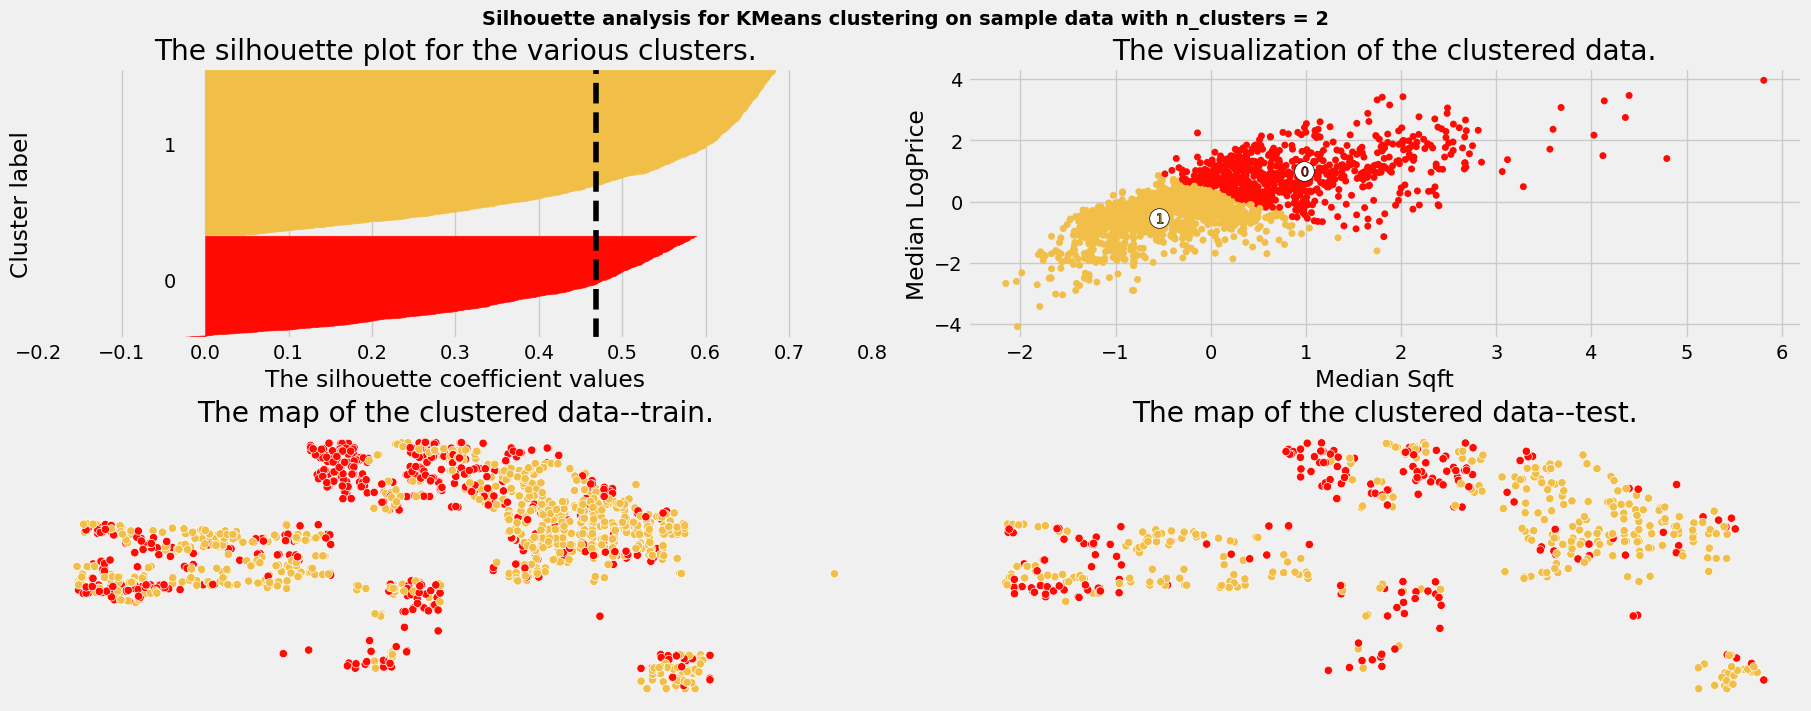

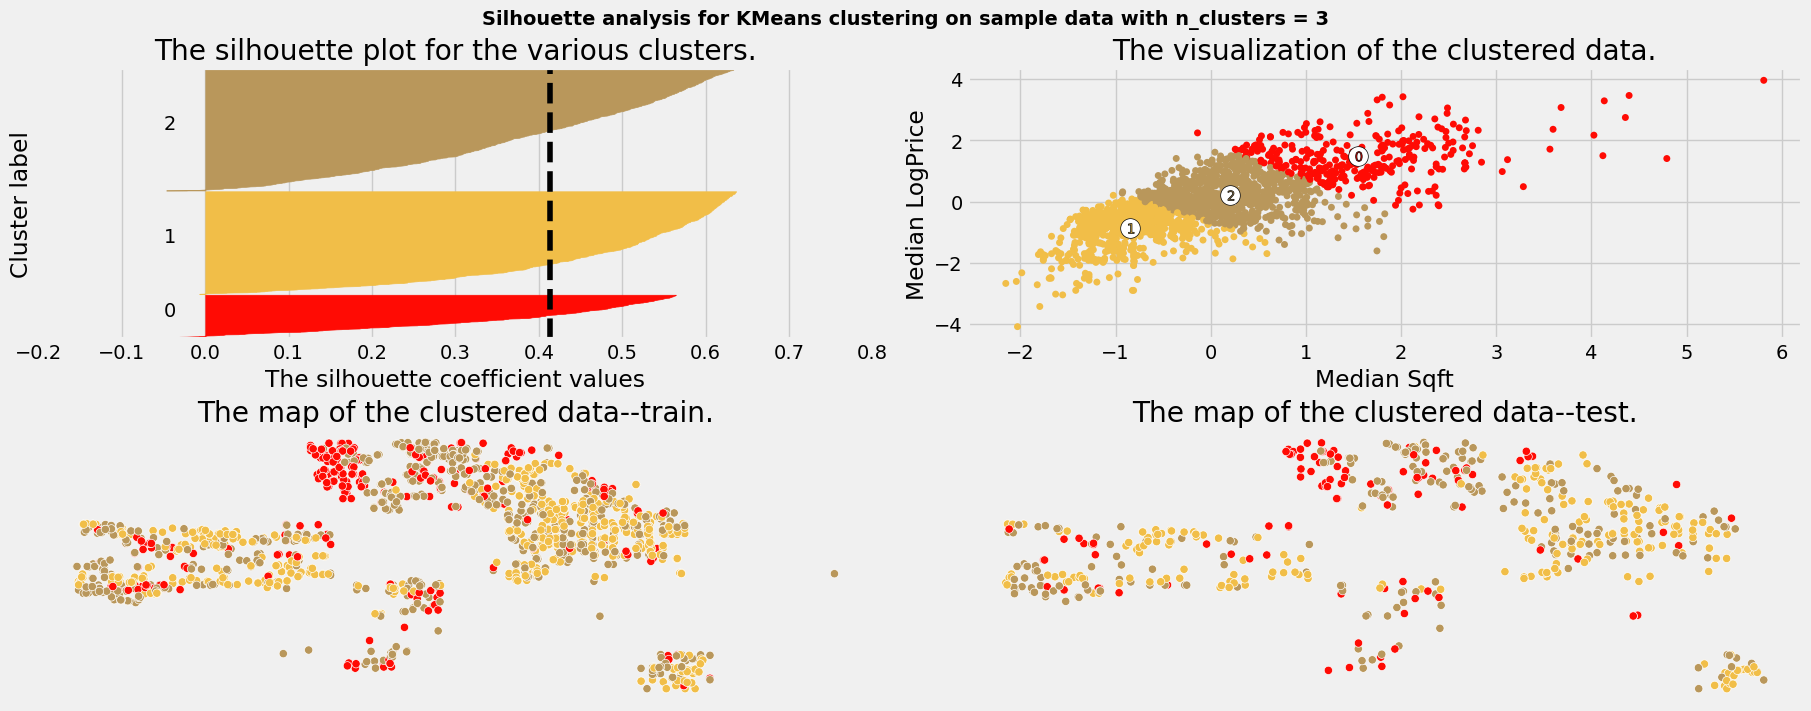

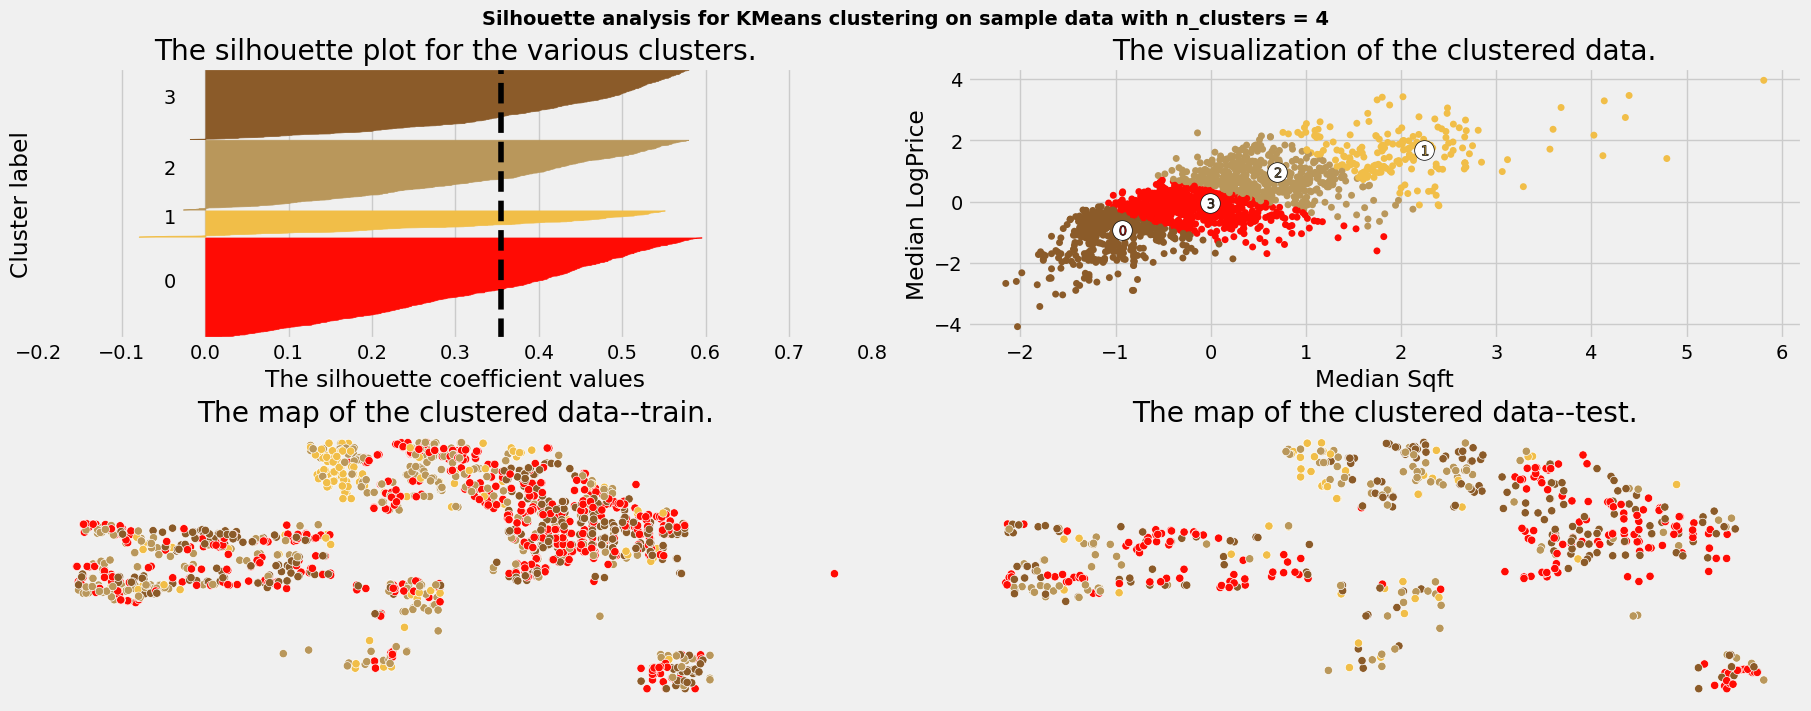

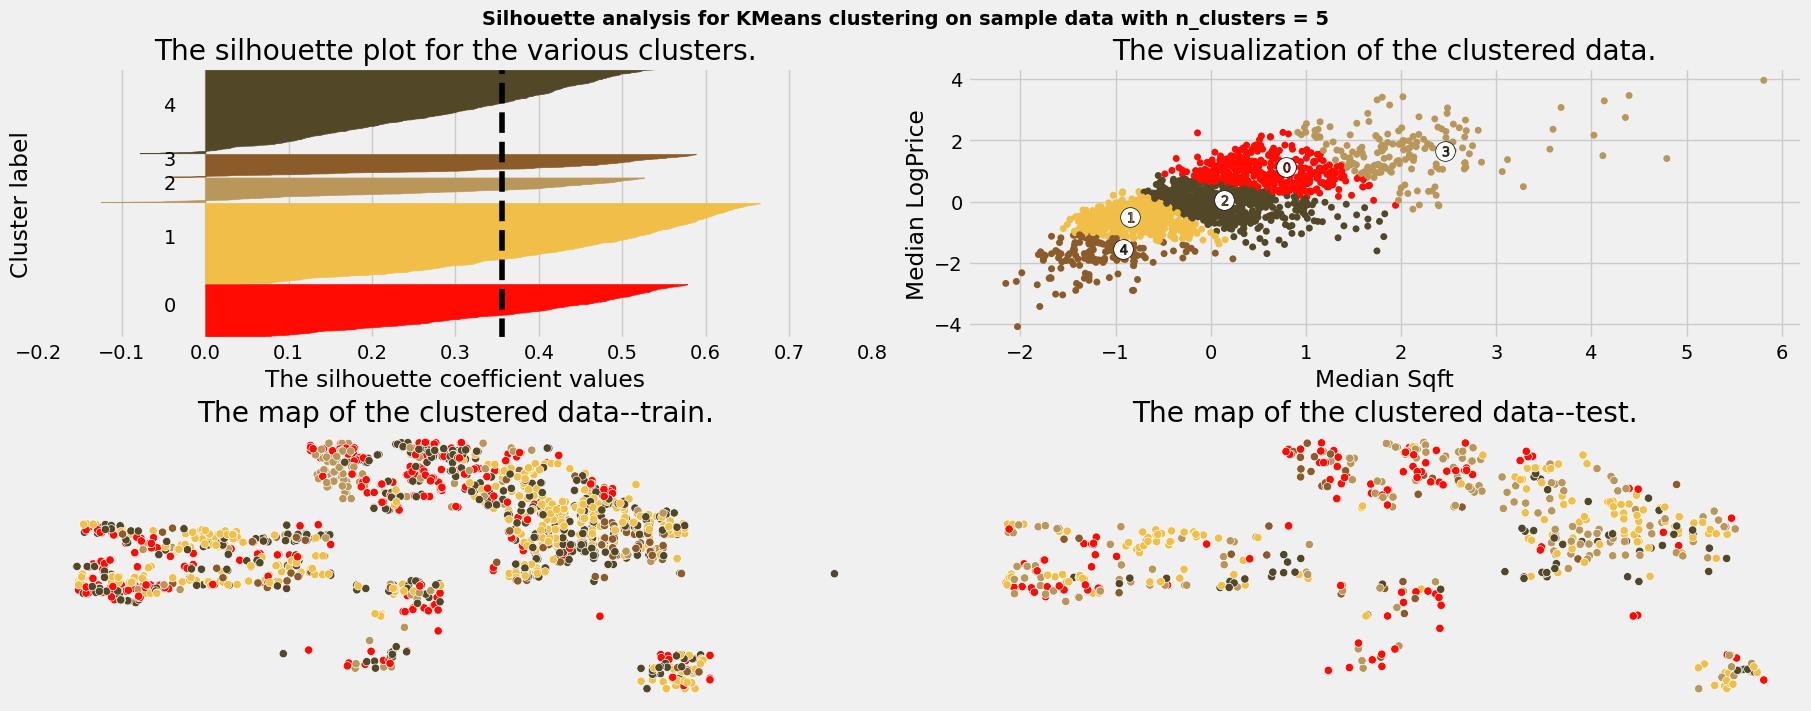

In [5]:
cluster_graphs(train, test, ['GrLivArea'])

#### ['GrLivArea','YearBuilt']

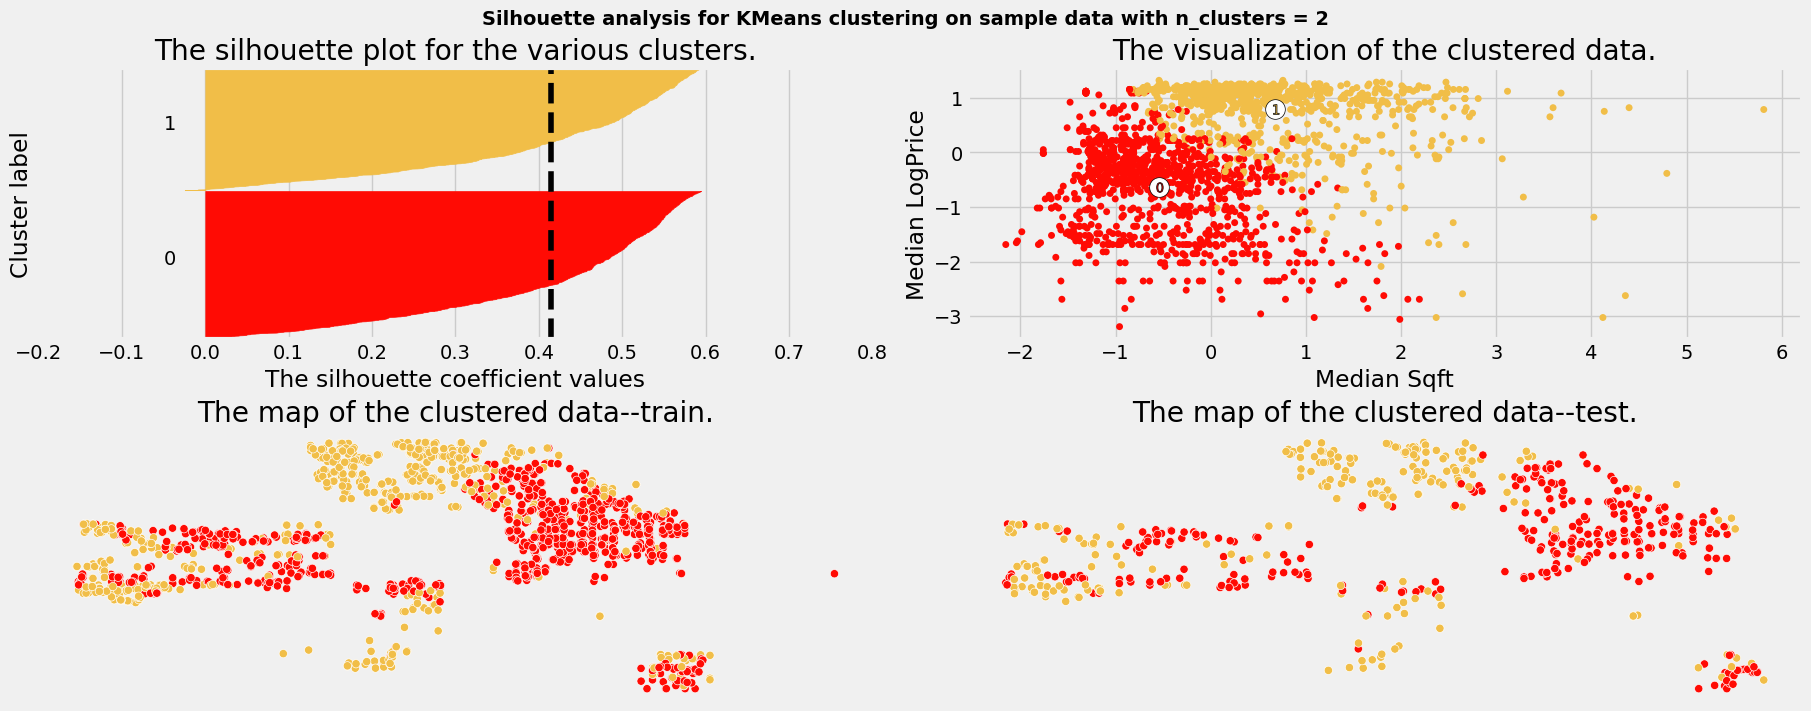

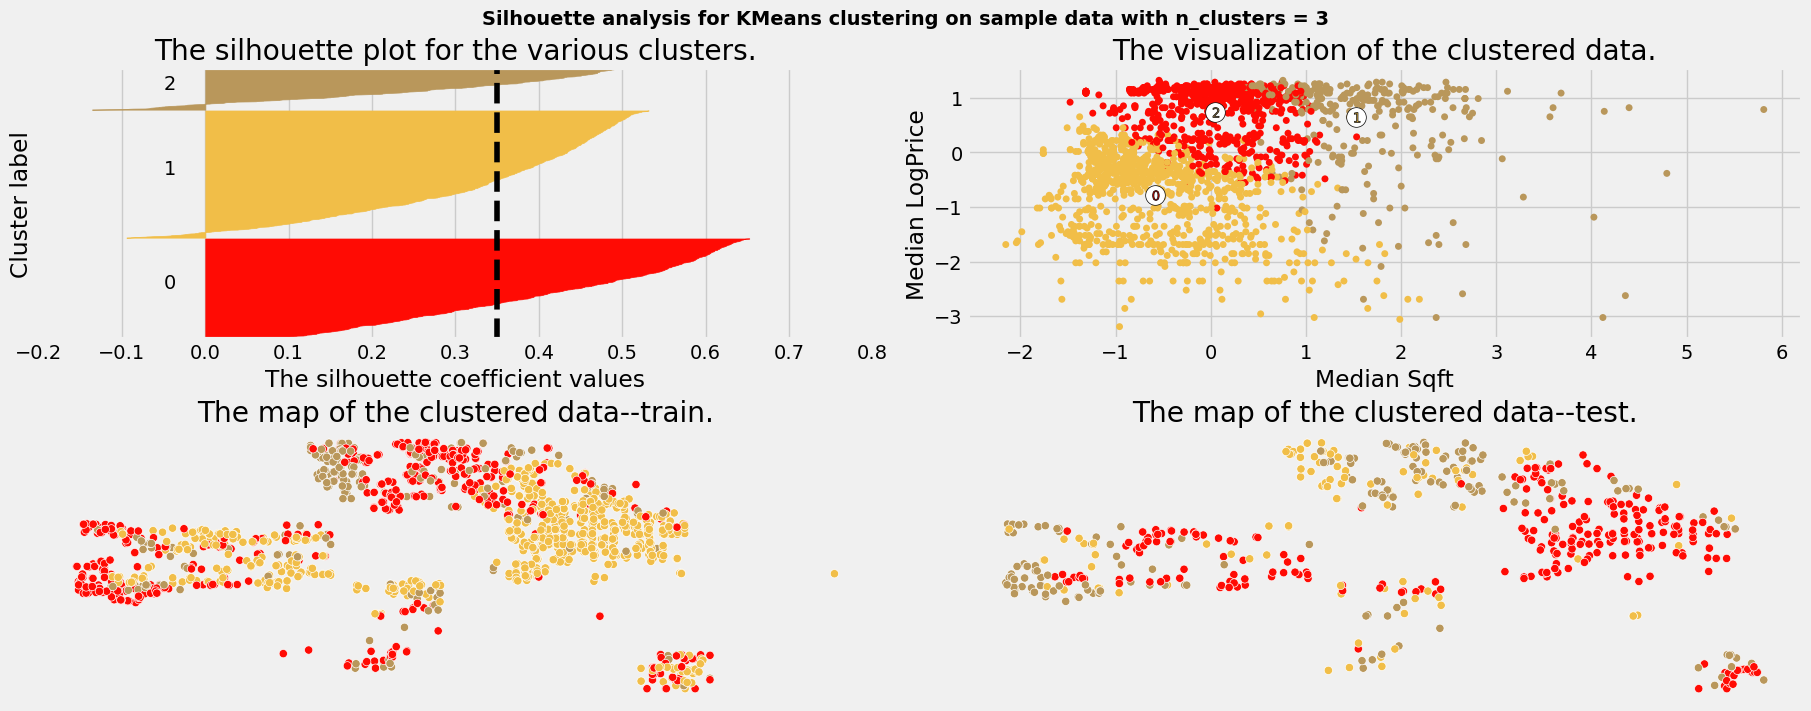

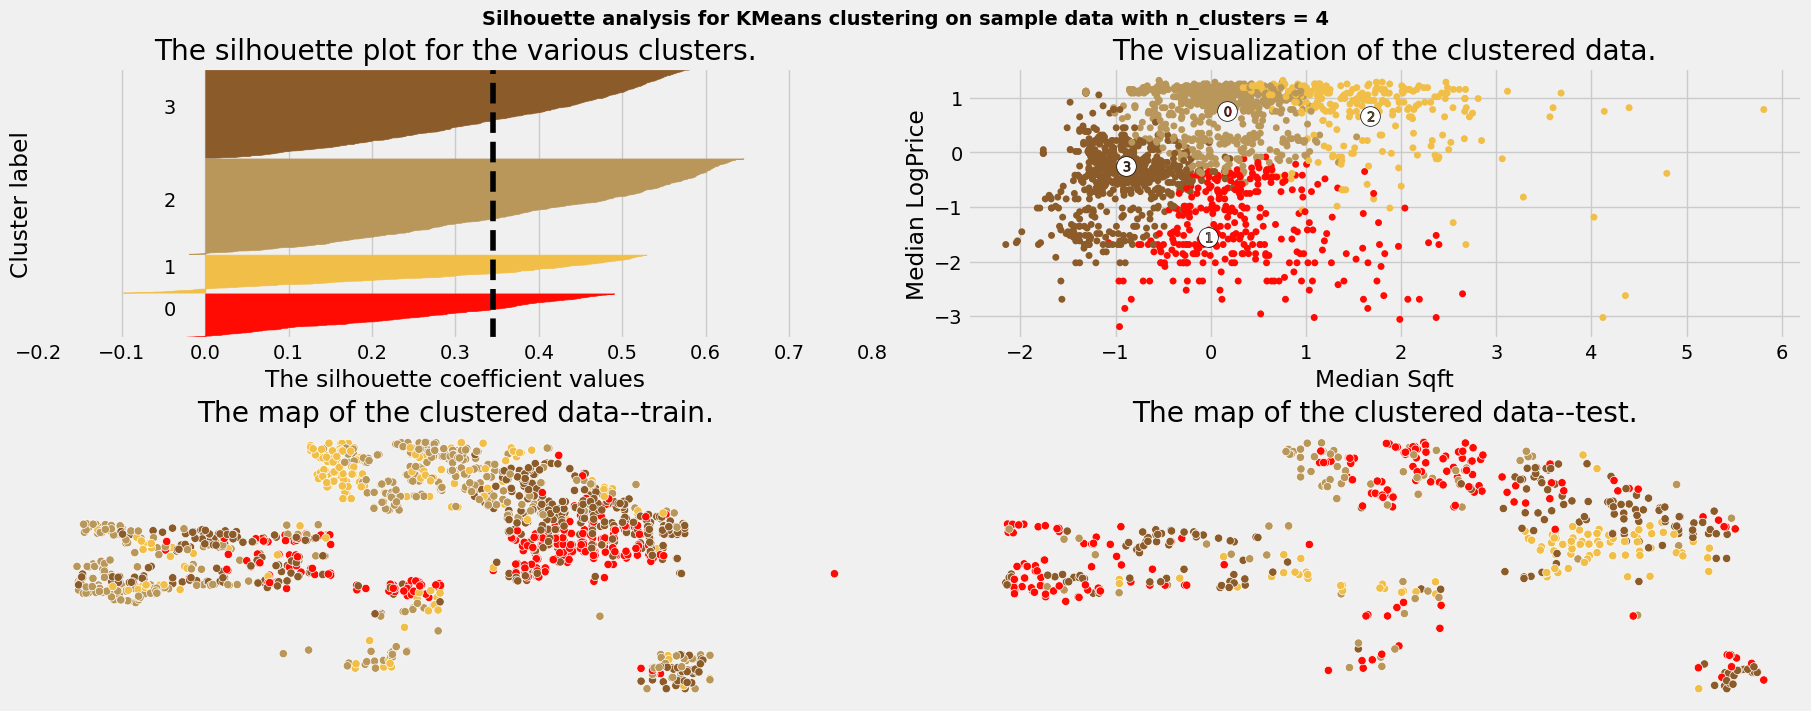

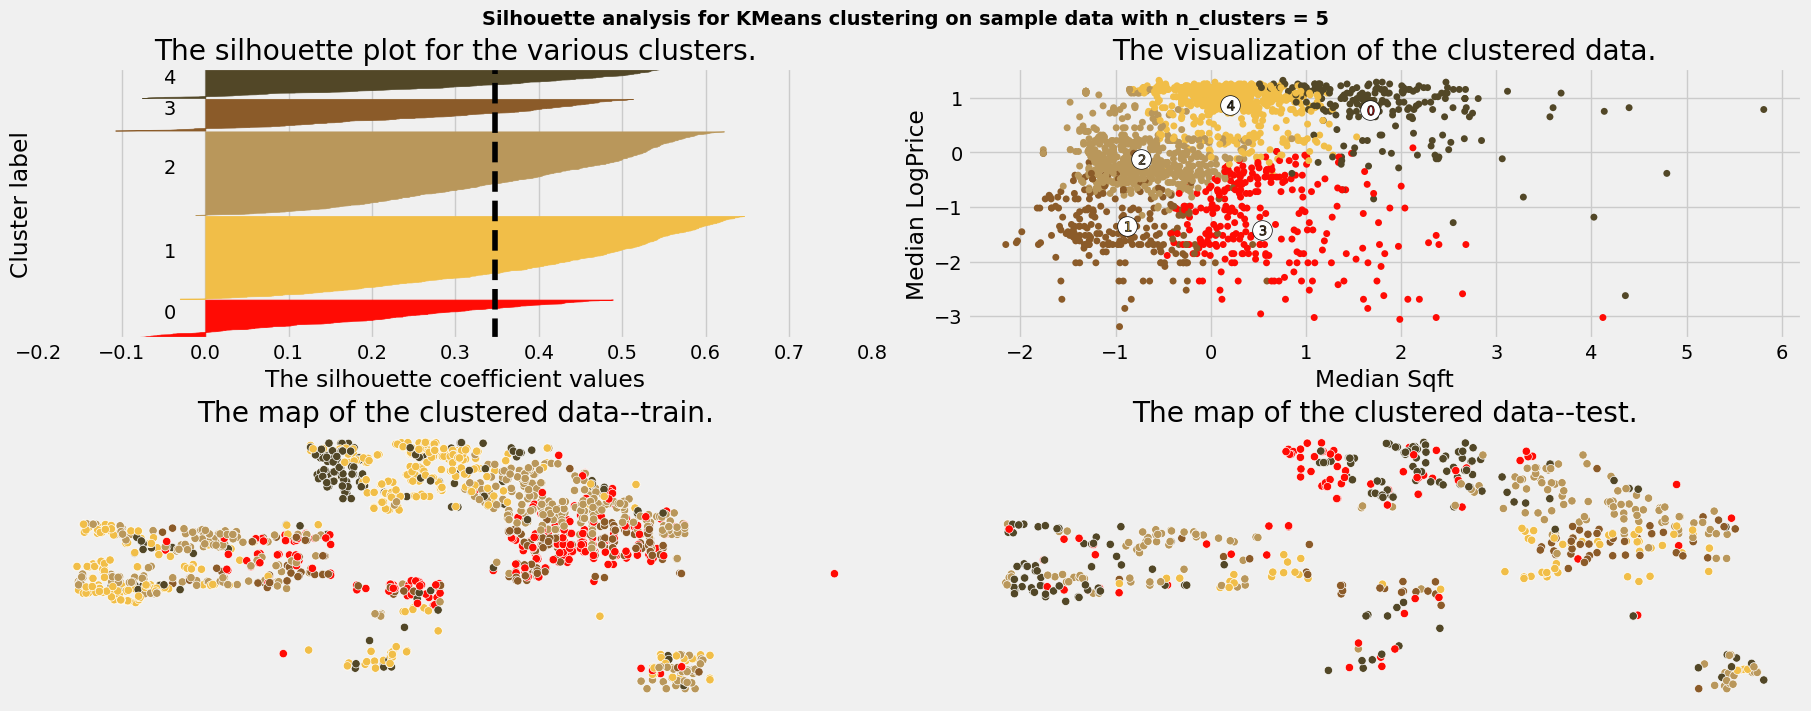

In [6]:
cluster_graphs(train, test, ['GrLivArea','YearBuilt',])

#### ['GrLivArea','YearBuilt','TotalBsmtSF']

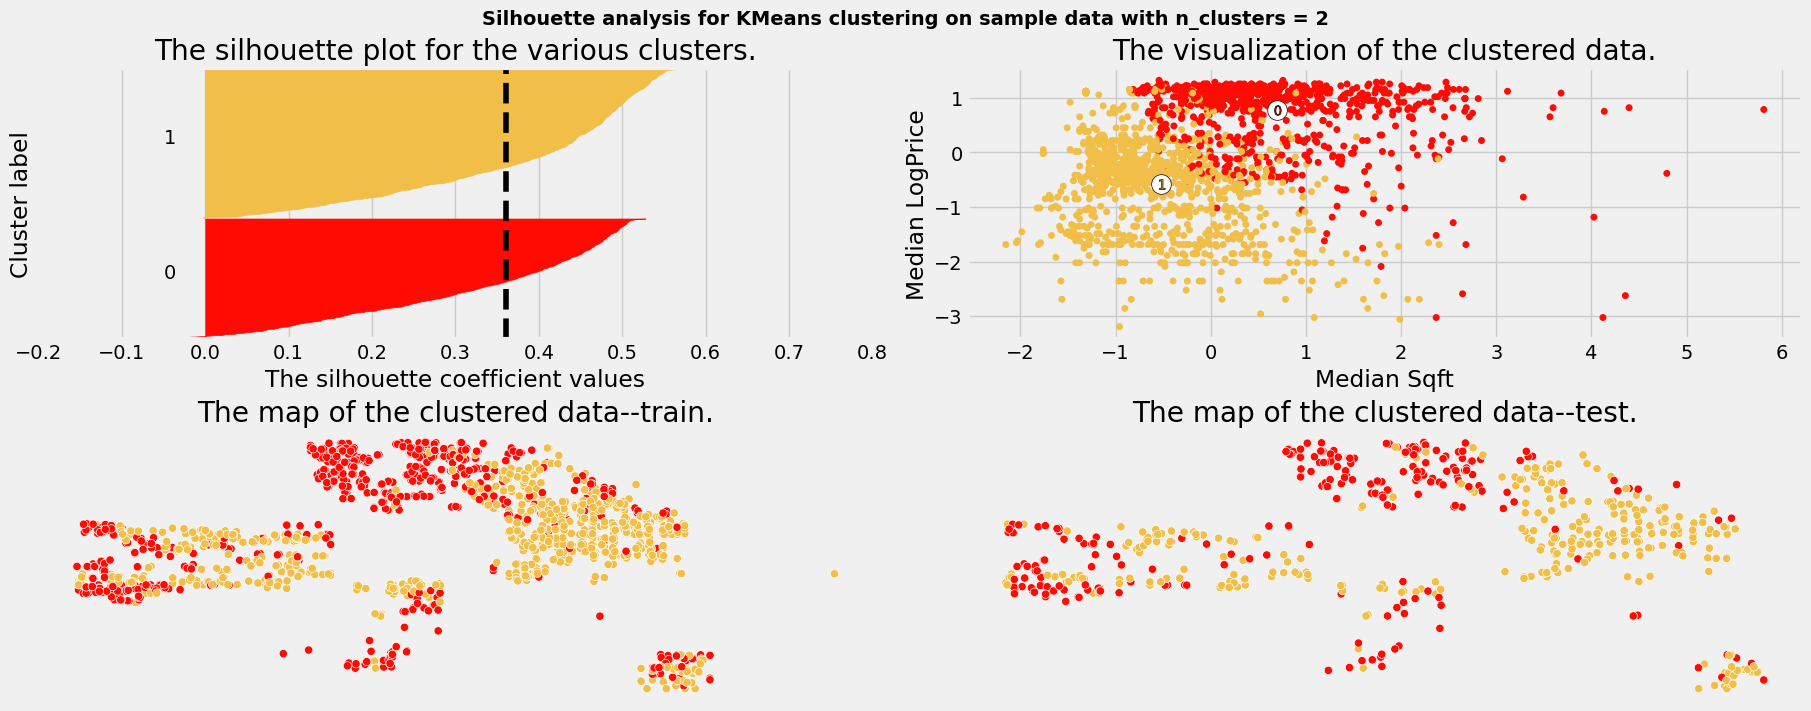

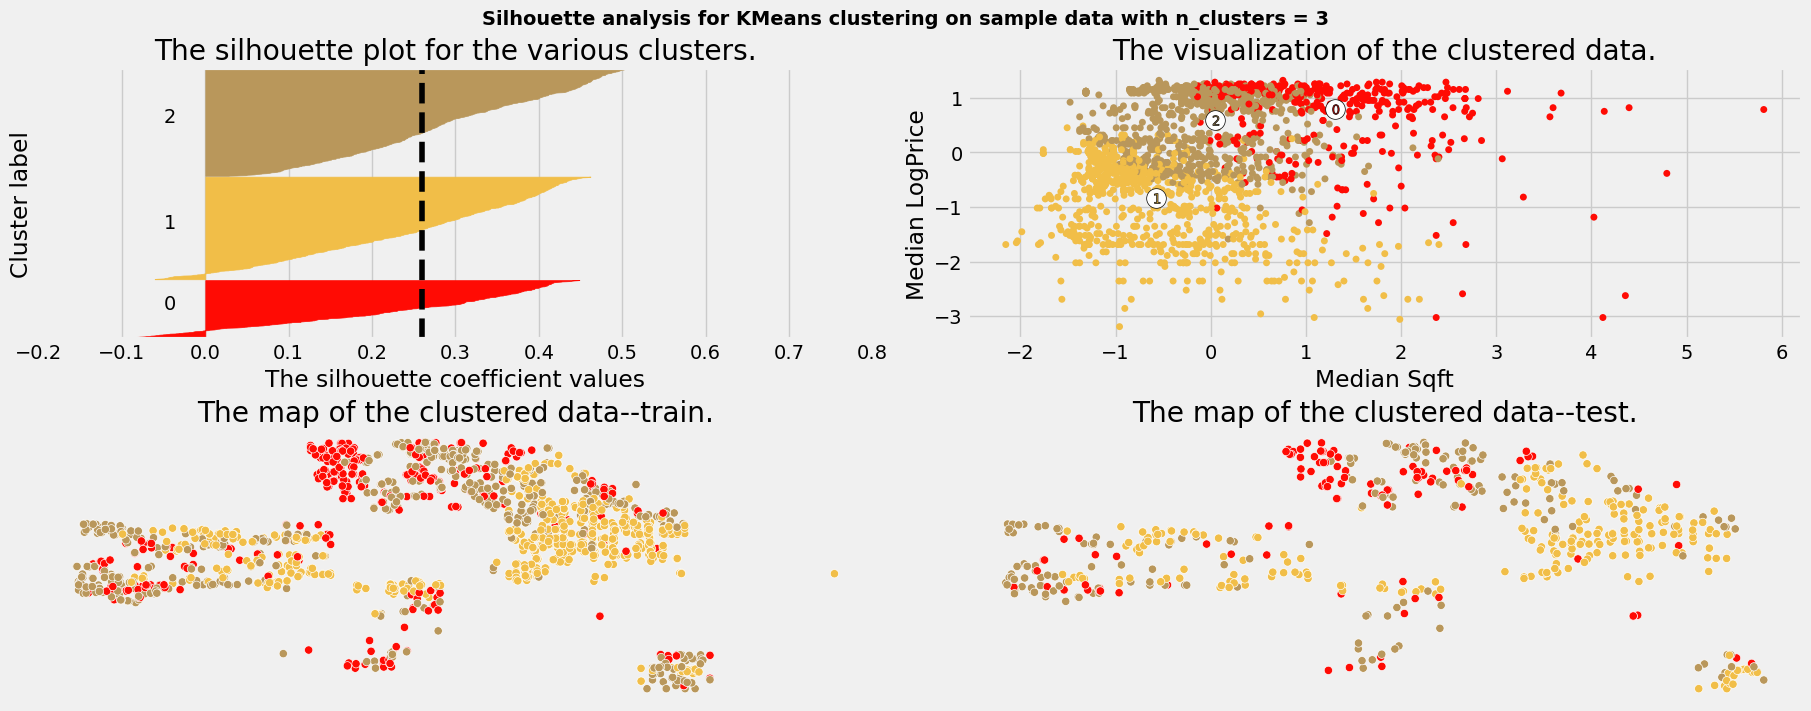

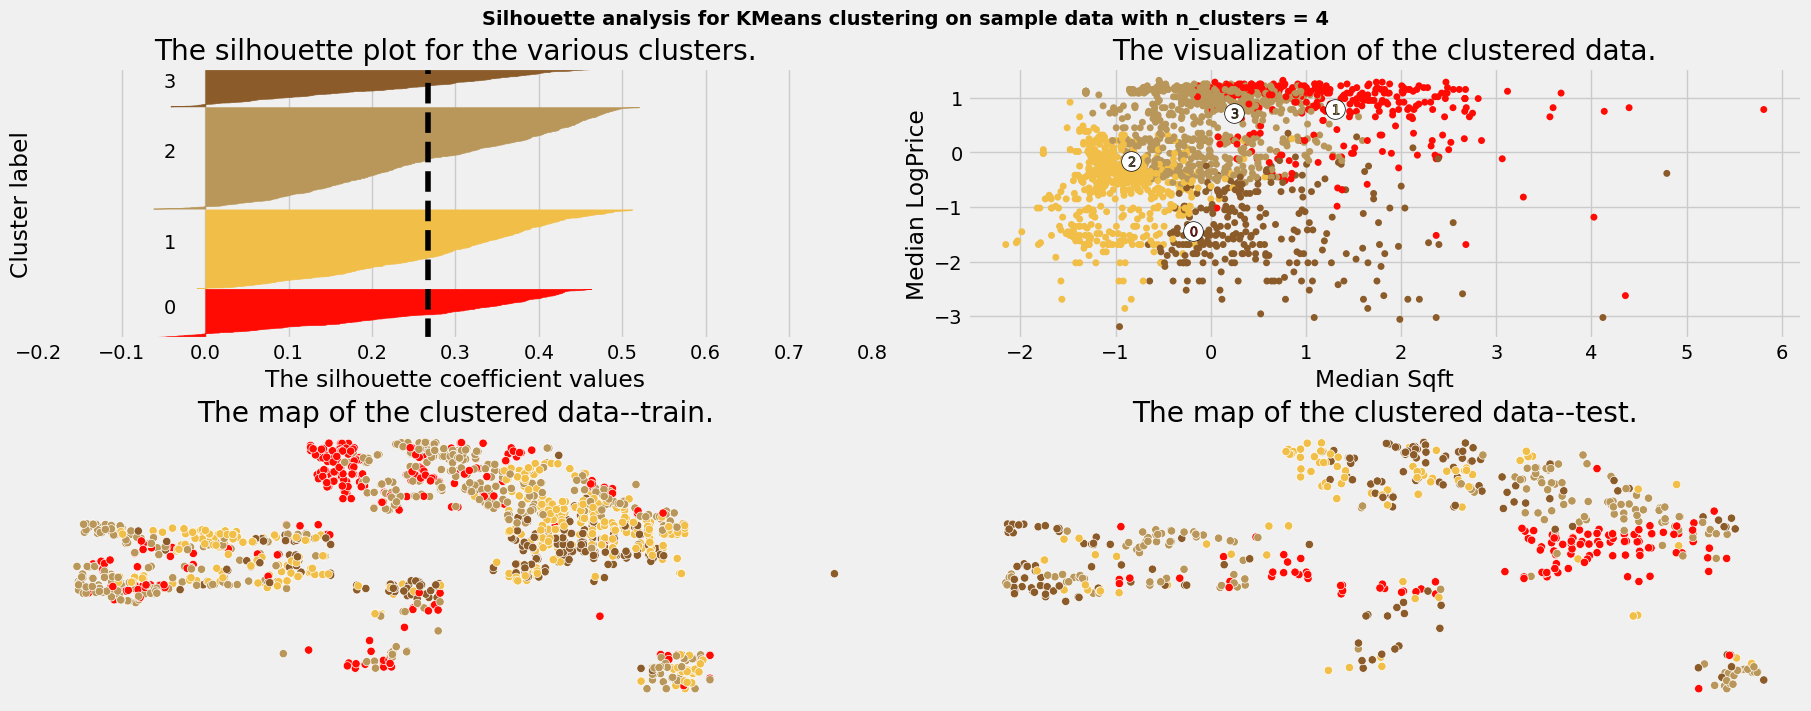

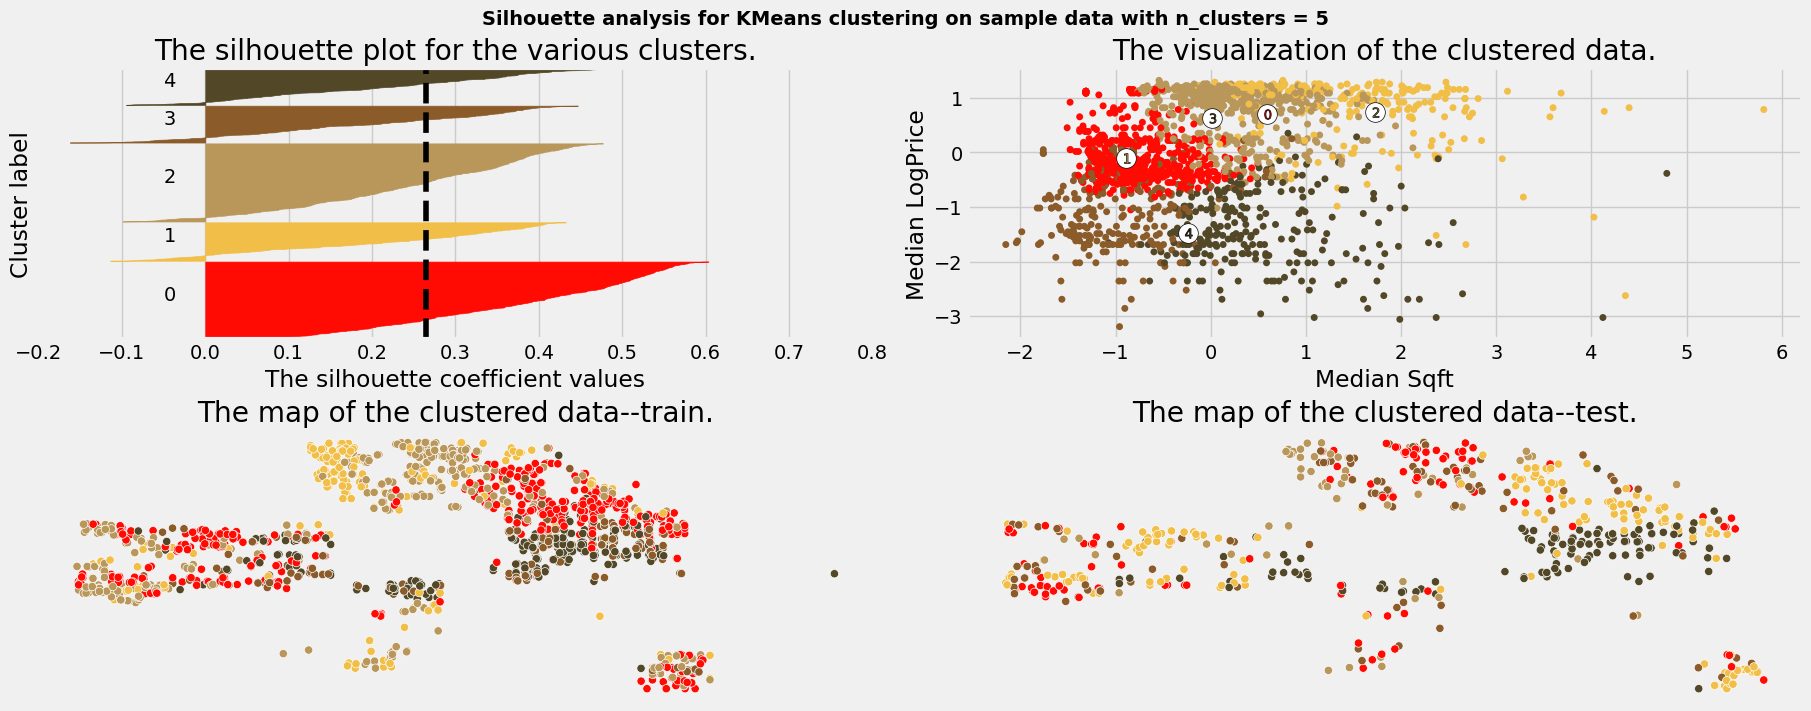

In [7]:
cluster_graphs(train, test, ['GrLivArea','YearBuilt','TotalBsmtSF'])